In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


   # of stores  train_dev_sample_and_batch_size   Architecture Class  n_stores  Train Loss  Dev Loss  Test Loss                                                                                                                                                                                                                                                       path  Optimality Gap %
0            3                              128  n_stores_shared_net         3    6.533234  6.607551   6.538737  /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00123_123_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-05-10_12-21-53          0.133804
1            3                             1024  n_stores_shared_net         3    6.511566  6.566057   6.530389  /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00105_105_config

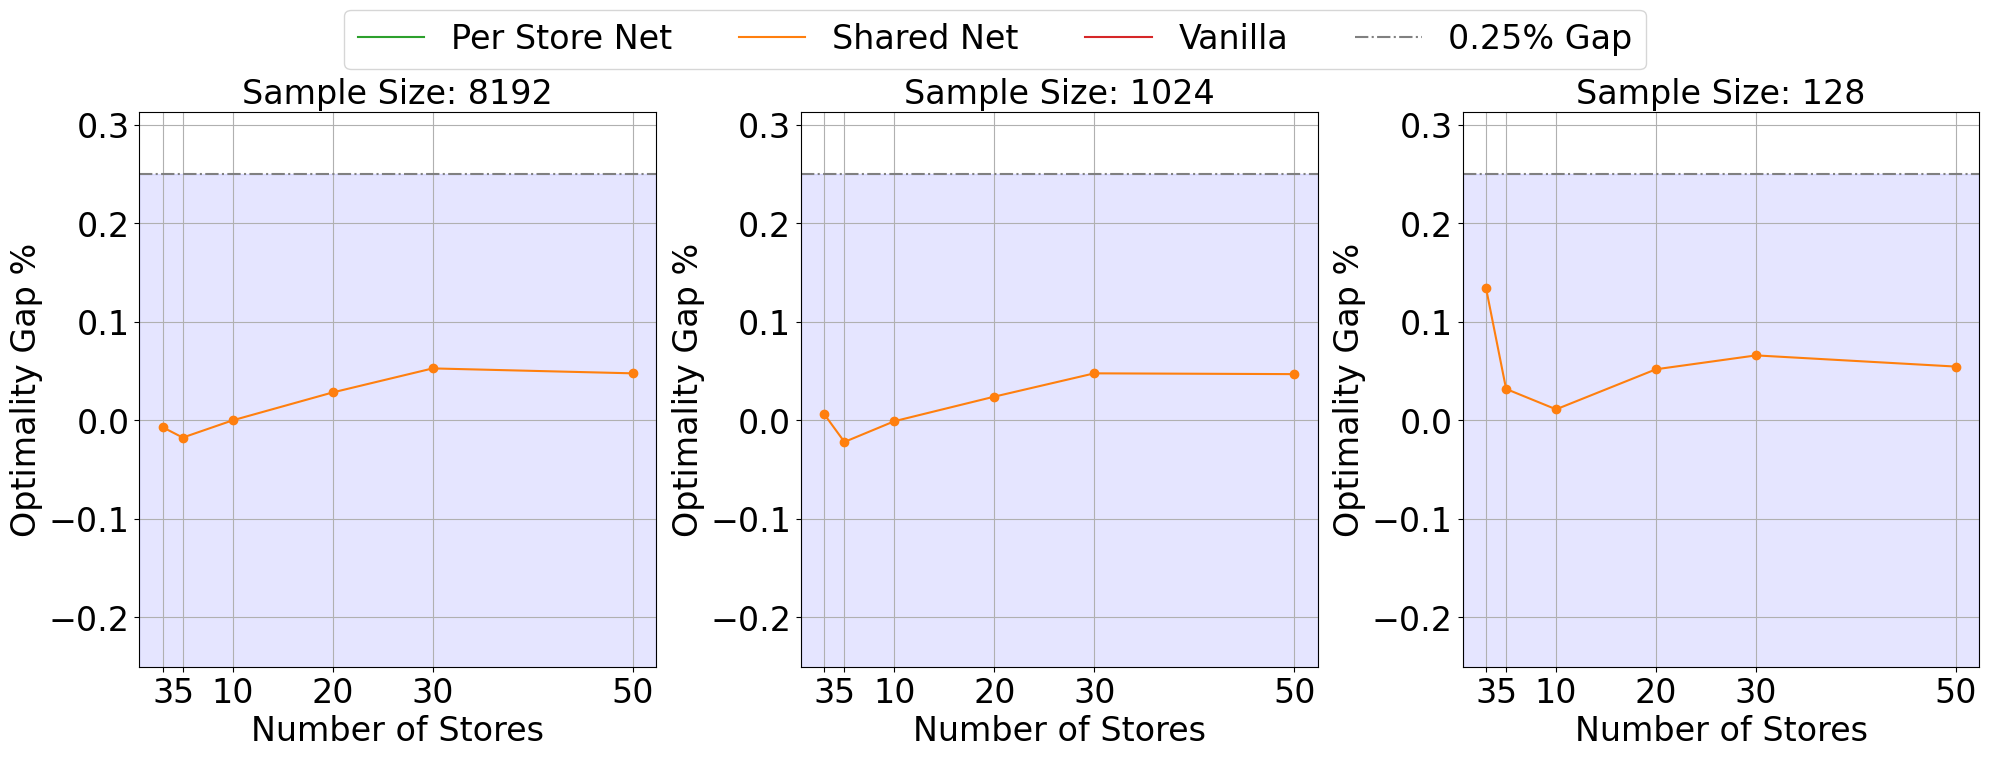

In [2]:
# Define color scheme for architecture types
color_scheme = {
    "n_stores_per_store_net": "#2ca02c",  # Green
    "n_stores_shared_net": "#ff7f0e",  # Orange
    "vanilla_n_stores": "#d62728"  # Red
}

testset_name = "finals_weight_sharing"

# Define architectures with their path patterns
architectures = {
    # "vanilla_n_stores": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/vanilla_n_stores',
    "n_stores_shared_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_shared_net',
    # "n_stores_per_store_net": lambda n: f'/user/ml4723/Prj/NIC/ray_results/{testset_name}/n_stores_per_store_net'
}

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'

# Define number of stores and sample sizes
n_stores = [3, 5, 10, 20, 30, 50]
sample_sizes = [8192, 1024, 128]
optimal_loss = 6.53  # Optimal loss value

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

results_interpretor = rri.RayResultsinterpreter()

dfs = []

# Create dataframes for each architecture, store size and sample size
for arch_name, path_fn in architectures.items():
    for n_store in n_stores:
        path = path_fn(n_store)
        df = results_interpretor.make_table({1: path},
            {'train_dev_sample_and_batch_size': sample_sizes, 'n_stores': n_store},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
        
        if not df.empty:
            df.insert(2, 'Architecture Class', arch_name)
            df.insert(1, 'hyperparam_name', arch_name)
            df['n_stores'] = n_store
            df['# of stores'] = n_store
            dfs.append(df)
df = pd.concat(dfs)

# Calculate optimality gap
df['Optimality Gap %'] = ((df['Test Loss'] - optimal_loss) / optimal_loss) * 100
df.insert(df.columns.get_loc(df.columns[-1]), 'Optimality Gap %', df.pop('Optimality Gap %'))
df.sort_values(by=['# of stores', 'train_dev_sample_and_batch_size'], inplace=True)

df_to_print = df.copy()
df_to_analyze = df_to_print.copy()
columns_to_drop = ['Learning Rate', 'include_context_for_warehouse_input', '# of runs', 'hyperparam_name', 'store_orders_for_warehouse']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create plot grid for different sample sizes
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, sample_size in enumerate(sample_sizes):
    df_sample = df[df['train_dev_sample_and_batch_size'] == sample_size]
    pivot_df = df_sample.groupby(['# of stores', 'Architecture Class'])['Optimality Gap %'].min().unstack()
    
    ax = axes[idx]
    for column in pivot_df.columns:
        ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
                marker='o',
                label=column,
                color=color_scheme[column],
                linestyle='-')  # All architectures use the same solid line style
    
    # Add 0.25% optimality gap reference line
    ax.axhline(y=0.25, color='gray', linestyle='-.', alpha=1.0, label='0.25% Gap')
    ax.axhspan(-1, 0.25, color='blue', alpha=0.1)
    
    font_size = 24
    ax.set_xlabel('Number of Stores', fontsize=font_size)
    # Always add y-label to all subplots
    ax.set_ylabel('Optimality Gap %', fontsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)
    ax.set_title(f'Sample Size: {sample_size}', fontsize=font_size)
    ax.grid(True)
    ax.set_xticks(pivot_df.index)
    ax.tick_params(axis='x', labelsize=font_size)  # Set x-axis tick font size
    ax.set_ylim(bottom=-0.25)  # Set y-axis limits

# Create a custom legend for the entire figure
custom_lines = [
    plt.Line2D([0], [0], color=color_scheme["n_stores_per_store_net"], linestyle='-', label='Per Store Net'),
    plt.Line2D([0], [0], color=color_scheme["n_stores_shared_net"], linestyle='-', label='Shared Net'),
    plt.Line2D([0], [0], color=color_scheme["vanilla_n_stores"], linestyle='-', label='Vanilla'),
    plt.Line2D([0], [0], color='gray', linestyle='-.', label='0.25% Gap')
]
fig.legend(handles=custom_lines, loc='upper center', fontsize=font_size, ncol=4, bbox_to_anchor=(0.5, 1.1))

plt.tight_layout()
plt.show()

In [9]:
df

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,n_stores,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,Optimality Gap %
0,3,n_stores_shared_net,128,n_stores_shared_net,3,0.0100,6.533234,6.607551,6.538737,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.133804
1,3,n_stores_shared_net,1024,n_stores_shared_net,3,0.0100,6.511566,6.566057,6.530389,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.005957
2,3,n_stores_shared_net,8192,n_stores_shared_net,3,0.0010,6.522468,6.547658,6.529538,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.007079
0,5,n_stores_shared_net,128,n_stores_shared_net,5,0.0010,6.522889,6.570317,6.532078,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.031824
1,5,n_stores_shared_net,1024,n_stores_shared_net,5,0.0010,6.515170,6.568235,6.528567,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.021939
2,5,n_stores_shared_net,8192,n_stores_shared_net,5,0.0010,6.528585,6.540184,6.528856,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.017512
0,10,n_stores_shared_net,128,n_stores_shared_net,10,0.0100,6.471813,6.553388,6.530729,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.011164
1,10,n_stores_shared_net,1024,n_stores_shared_net,10,0.0010,6.535009,6.557495,6.529942,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.000882
2,10,n_stores_shared_net,8192,n_stores_shared_net,10,0.0100,6.530156,6.544592,6.530001,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.000015
0,20,n_stores_shared_net,128,n_stores_shared_net,20,0.0100,6.513370,6.577030,6.533383,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.051812


In [24]:
df_debug = df
df_debug

,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,n_stores,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,Optimality Gap %
0,3,n_stores_shared_net,128,n_stores_shared_net,3,0.0100,6.533234,6.607551,6.538737,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.133804
1,3,n_stores_shared_net,1024,n_stores_shared_net,3,0.0100,6.511566,6.566057,6.530389,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.005957
2,3,n_stores_shared_net,8192,n_stores_shared_net,3,0.0010,6.522468,6.547658,6.529538,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.007079
0,5,n_stores_shared_net,128,n_stores_shared_net,5,0.0010,6.522889,6.570317,6.532078,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.031824
1,5,n_stores_shared_net,1024,n_stores_shared_net,5,0.0010,6.515170,6.568235,6.528567,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.021939
2,5,n_stores_shared_net,8192,n_stores_shared_net,5,0.0010,6.528585,6.540184,6.528856,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.017512
0,10,n_stores_shared_net,128,n_stores_shared_net,10,0.0100,6.471813,6.553388,6.530729,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.011164
1,10,n_stores_shared_net,1024,n_stores_shared_net,10,0.0010,6.535009,6.557495,6.529942,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,-0.000882
2,10,n_stores_shared_net,8192,n_stores_shared_net,10,0.0100,6.530156,6.544592,6.530001,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.000015
0,20,n_stores_shared_net,128,n_stores_shared_net,20,0.0100,6.513370,6.577030,6.533383,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.051812


In [25]:
df_debug = df_debug[df_debug["train_dev_sample_and_batch_size"] == 128]
df_debug = df_debug[df_debug["n_stores"] == 50]
df_debug


,# of stores,hyperparam_name,train_dev_sample_and_batch_size,Architecture Class,n_stores,Learning Rate,Train Loss,Dev Loss,Test Loss,# of runs,path,Optimality Gap %
0,50,n_stores_shared_net,128,n_stores_shared_net,50,0.0001,6.53164,6.567984,6.533561,9,/user/ml4723/Prj/NIC/ray_results/finals_weight...,0.054532


In [23]:
mode = "test"
setting_name = 'n_stores_lost_demand_optimal'

models = {}
# Create a dictionary where keys are store counts and values are model paths
for _, row in df_debug.iterrows():
    models[str(row['# of stores']) + '_' + str(row['train_dev_sample_and_batch_size'])] = str(row['path']) + '/model.pt'

def run_main_run(model_path, identifier):
    try:
        # Extract hyperparam name from model path
        hyperparam_name = model_path.split('/')[7]
        print(f"Running main_run.py for path {model_path}")
        cmd = [
            "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
            "main_run.py",
            mode, # test or test_on_dev
            setting_name,
            hyperparam_name,
            model_path,
            identifier,
            identifier
        ]
        env = {
            **os.environ,
            "MKL_THREADING_LAYER": "GNU",
            "MKL_SERVICE_FORCE_INTEL": "1"
        }
        subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
    except subprocess.CalledProcessError as e:
        print(f"Error running main_run.py for path {model_path}: {e}")
        print(f"Error output: {e.stderr}")
    except Exception as e:
        print(f"Unexpected error running main_run.py for path {model_path}: {e}")

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = []
    for identifier, path in models.items():
        while len(futures) >= 8:
            done, not_done = concurrent.futures.wait(
                futures, 
                return_when=concurrent.futures.FIRST_COMPLETED
            )
            futures = list(not_done)
        futures.append(executor.submit(run_main_run, path, identifier))
    concurrent.futures.wait(futures)


Running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00110_110_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-05-10_12-21-53/model.pt
Error running main_run.py for path /user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00110_110_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-05-10_12-21-53/model.pt: Command '['/user/ml4723/.conda/envs/neural_inventory_control/bin/python', 'main_run.py', 'test', 'n_stores_lost_demand_optimal', 'n_stores_shared_net', '/user/ml4723/Prj/NIC/ray_results/finals_weight_sharing/n_stores_shared_net/run_2025-05-10_12-21-51/run_e11dd_00110_110_config=n_stores_lost_demand_optimal,different_for_each_sample=True,early_stop_check_epochs=10,learning_rate=0._2025-05-10_12-21-53/model.pt', '50

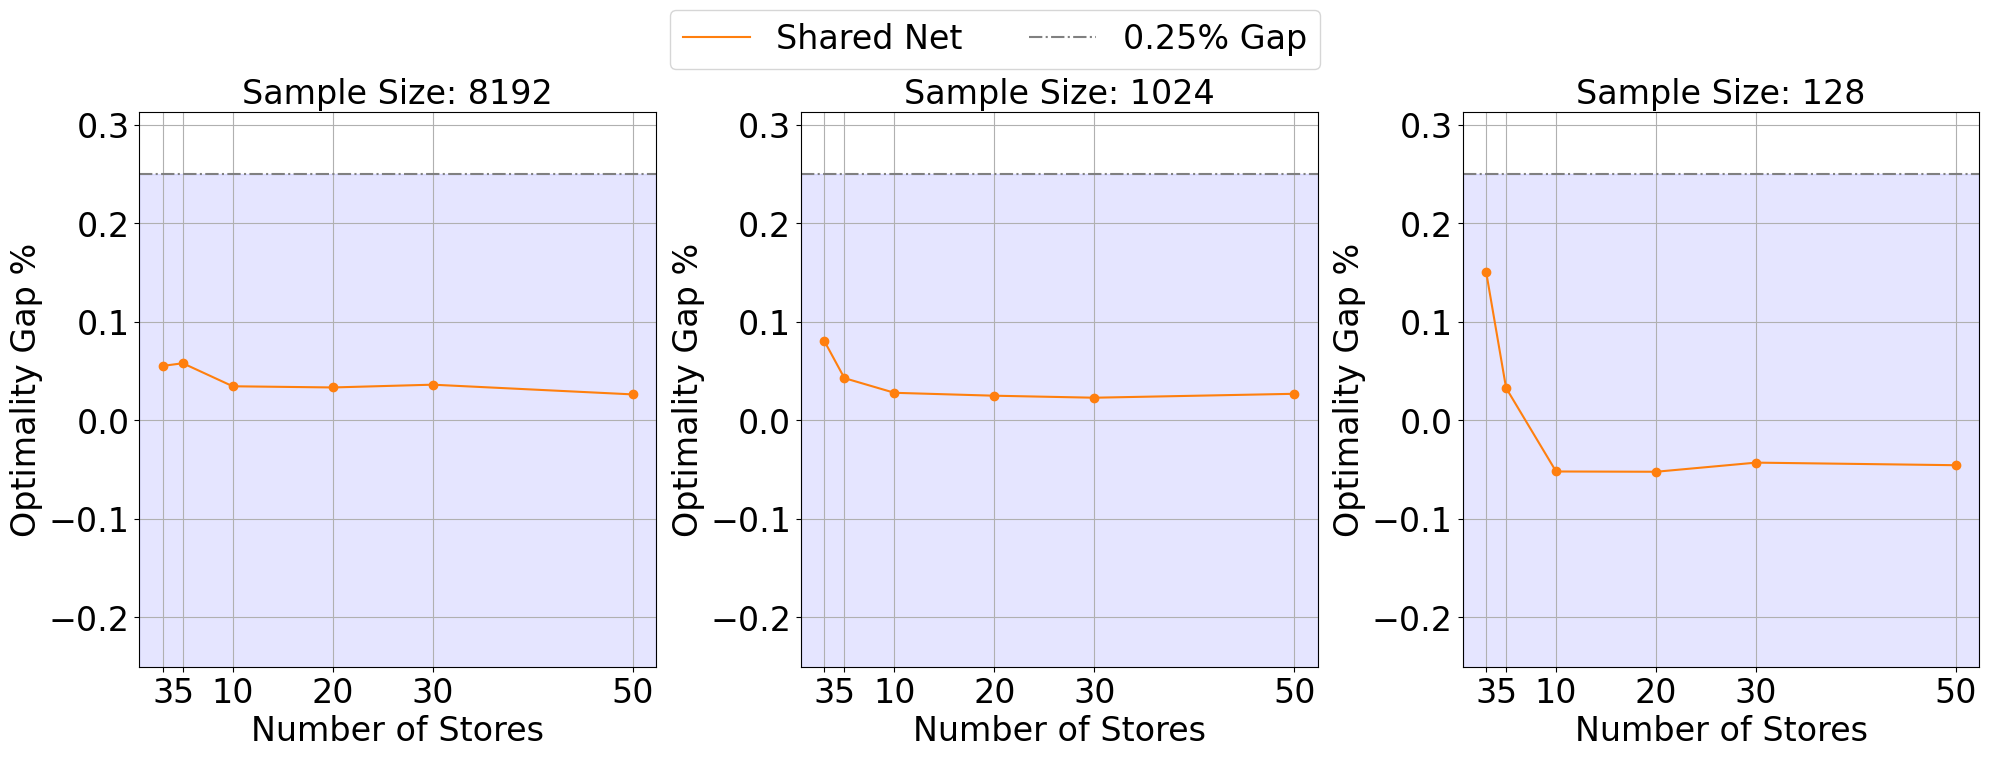

In [26]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Define constants
optimal_loss = 6.53  # Optimal loss value
sample_sizes = [8192, 1024, 128]
n_stores_list = [3, 5, 10, 20, 30, 50]

# Define color scheme
color_scheme = {
    "n_stores_shared_net": "#ff7f0e",  # Orange
}

# Function to get relevant indices
def get_relevant_indices(n_samples, batch_size, num_steps, start_step):
    num_batches = n_samples // batch_size
    relevant_indices = []
    for batch in range(num_batches):
        batch_start = batch * batch_size * num_steps
        step_start = batch_start + start_step * batch_size
        step_end = batch_start + num_steps * batch_size
        relevant_indices.extend(range(step_start, step_end))
    return relevant_indices

# Process results for each store configuration and sample size
results_by_sample_size = {sample_size: {} for sample_size in sample_sizes}

# Process data from CSV files
for n_stores in n_stores_list:
    for sample_size in sample_sizes:
        # Set batch size equal to sample size for each configuration
        batch_size = sample_size
        num_steps = 10000
        start_step = 300
        
        # Get relevant indices for this specific sample size
        relevant_indices = get_relevant_indices(sample_size, batch_size, num_steps, start_step)
        
        # Construct the path to the CSV file
        csv_path = f"/user/ml4723/Prj/NIC/analysis/results/n_stores_lost_demand_optimal/{n_stores}-0/{n_stores}_{sample_size}.csv"
        
        if os.path.exists(csv_path):
            # Read data
            data = pd.read_csv(csv_path)
            if len(data) > 0:
                relevant_data = data.iloc[relevant_indices] if len(data) > max(relevant_indices) else data
                
                # Calculate normalization factor
                normalization_factor = (num_steps - start_step) * n_stores * sample_size
                
                # Get normalized costs
                underage_cost = relevant_data['s_underage_costs'].sum() / normalization_factor
                store_holding_cost = relevant_data['s_holding_costs'].sum() / normalization_factor
                
                # Calculate total cost from normalized components
                total_cost = underage_cost + store_holding_cost
                
                # Calculate optimality gap
                optimality_gap = ((total_cost - optimal_loss) / optimal_loss) * 100
                results_by_sample_size[sample_size][n_stores] = optimality_gap

# Create plot grid for different sample sizes
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for idx, sample_size in enumerate(sample_sizes):
    ax = axes[idx]
    
    # Extract data for this sample size
    store_counts = []
    gaps = []
    
    for n_store in n_stores_list:
        if n_store in results_by_sample_size[sample_size]:
            store_counts.append(n_store)
            gaps.append(results_by_sample_size[sample_size][n_store])
    
    if store_counts:
        # Plot the data
        ax.plot(store_counts, gaps, marker='o', 
                color=color_scheme["n_stores_shared_net"], 
                linestyle='-', 
                label="n_stores_shared_net")
        
        # Add 0.25% optimality gap reference line
        ax.axhline(y=0.25, color='gray', linestyle='-.', alpha=1.0, label='0.25% Gap')
        ax.axhspan(-1, 0.25, color='blue', alpha=0.1)
        
        font_size = 24
        ax.set_xlabel('Number of Stores', fontsize=font_size)
        ax.set_ylabel('Optimality Gap %', fontsize=font_size)
        ax.tick_params(axis='y', labelsize=font_size)
        ax.set_title(f'Sample Size: {sample_size}', fontsize=font_size)
        ax.grid(True)
        ax.set_xticks(store_counts)
        ax.tick_params(axis='x', labelsize=font_size)
        ax.set_ylim(bottom=-0.25)

# Create a custom legend for the entire figure
custom_lines = [
    plt.Line2D([0], [0], color=color_scheme["n_stores_shared_net"], linestyle='-', label='Shared Net'),
    plt.Line2D([0], [0], color='gray', linestyle='-.', label='0.25% Gap')
]

fig.legend(handles=custom_lines, loc='upper center', fontsize=font_size, ncol=2, bbox_to_anchor=(0.5, 1.1))
plt.tight_layout()
plt.show()